In [6]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from train import train_epoch_mmd
from utils import plot_train, preproc_filter, load_batches, vis_embedding
from dataset import dataset
from scipy import sparse

import utils
import model
import train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [2]:
class dataset(Dataset):
    """\
        Description:
        ------------
            Create Pytorch Dataset

        Parameters:
        ------------
            counts: gene count. Type: numpy ndarrary
            anchor: anchor index. Type: numpy ndarray.
        
        Return:
        ------------
            Dataset
        """
    def __init__(self, counts, anno):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        
        self.counts = torch.FloatTensor(counts)
        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = anno
        self.libsizes = torch.FloatTensor(self.libsizes)     

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [3]:
dir = './data/Pancreas/'
batchsize = 32
nbatches = 8
seed = 0
# obtain the feature name
genes = pd.read_csv(dir + "gene.csv", header = None).values.squeeze()
ngenes = genes.shape[0]

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
train_loaders = []
test_loaders = []
for batch in range(nbatches):
    counts_rna = np.array(sparse.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
    anno = pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze()
    # preprocess the count matrix
    sc_dataset = dataset(counts = counts_rna, anno = anno)
    sc_datasets.append(sc_dataset)
    train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
    test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))


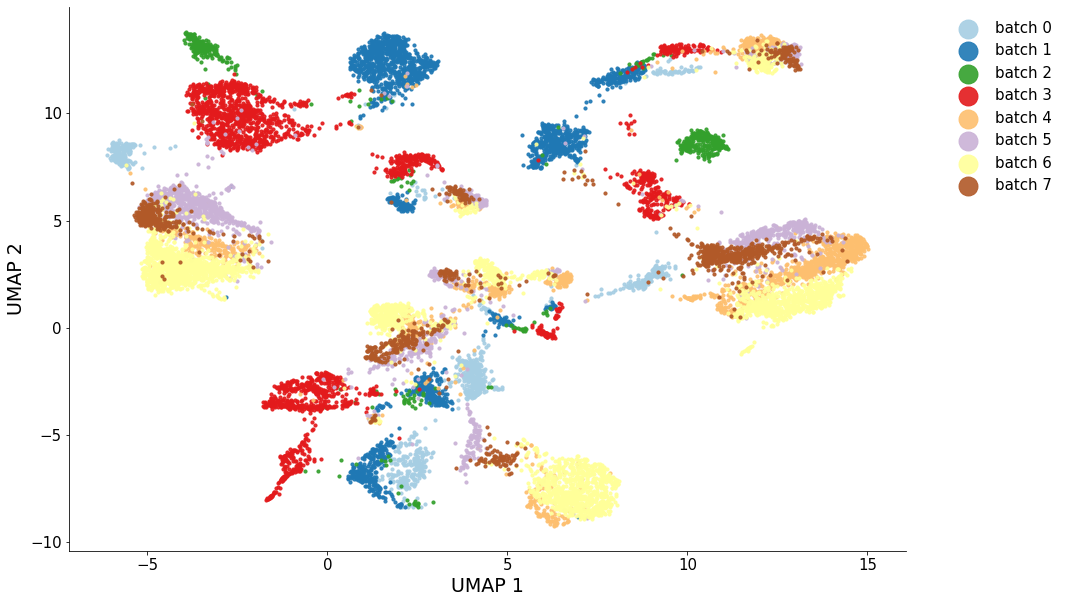

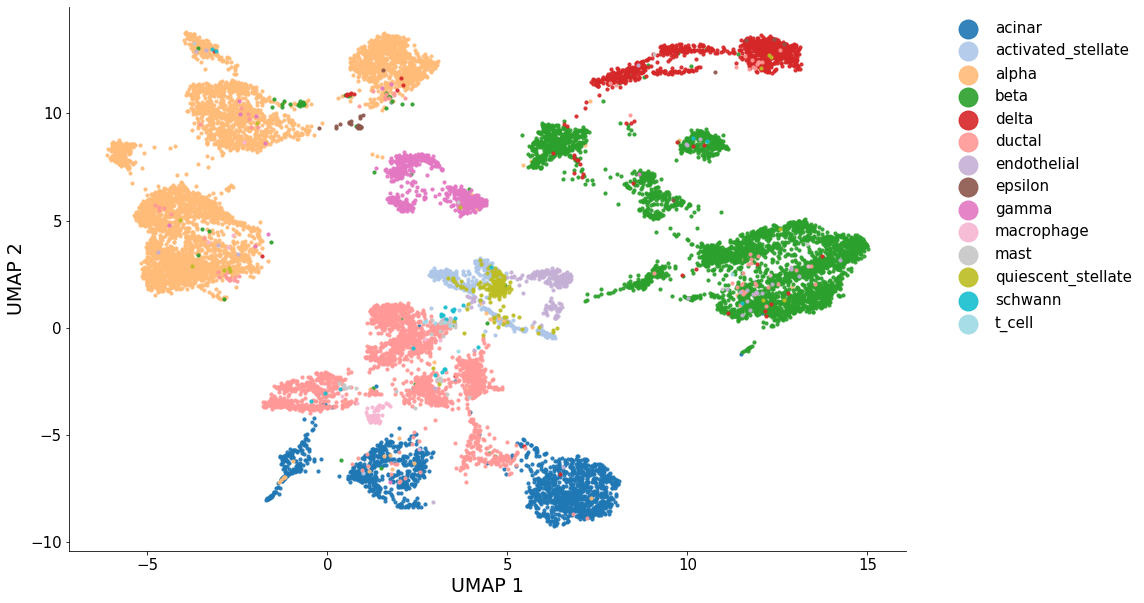

In [4]:
# before integration
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
counts_norms = []
annos = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets[batch].counts_norm)
    annos.append(sc_datasets[batch].anno)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [5]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [15]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)

# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)

losses = train.train_epoch_mmd(model_dict, train_data_loaders = train_loaders, test_data_loaders = test_loaders, 
                      optimizer = optim_ae, n_epoches = 100, interval = 10, lamb_mmd = 1, 
                      lamb_pi = 1e-5, use_zinb = True)



epoch:  0
	 mmd loss: 0.150
	 ZINB loss: 23.768
	 overall loss: 23.918
epoch:  10
	 mmd loss: 0.074
	 ZINB loss: 13.471
	 overall loss: 13.545
epoch:  20
	 mmd loss: 0.067
	 ZINB loss: 11.854
	 overall loss: 11.920
epoch:  30
	 mmd loss: 0.066
	 ZINB loss: 11.695
	 overall loss: 11.761
epoch:  40
	 mmd loss: 0.063
	 ZINB loss: 11.654
	 overall loss: 11.717
epoch:  50
	 mmd loss: 0.052
	 ZINB loss: 11.612
	 overall loss: 11.664
epoch:  60
	 mmd loss: 0.049
	 ZINB loss: 11.624
	 overall loss: 11.673
epoch:  70
	 mmd loss: 0.051
	 ZINB loss: 11.682
	 overall loss: 11.733
epoch:  80
	 mmd loss: 0.048
	 ZINB loss: 11.636
	 overall loss: 11.685
epoch:  90
	 mmd loss: 0.042
	 ZINB loss: 11.634
	 overall loss: 11.676
epoch:  100
	 mmd loss: 0.046
	 ZINB loss: 11.616
	 overall loss: 11.662


## Loss plot
The change of loss function with iterations

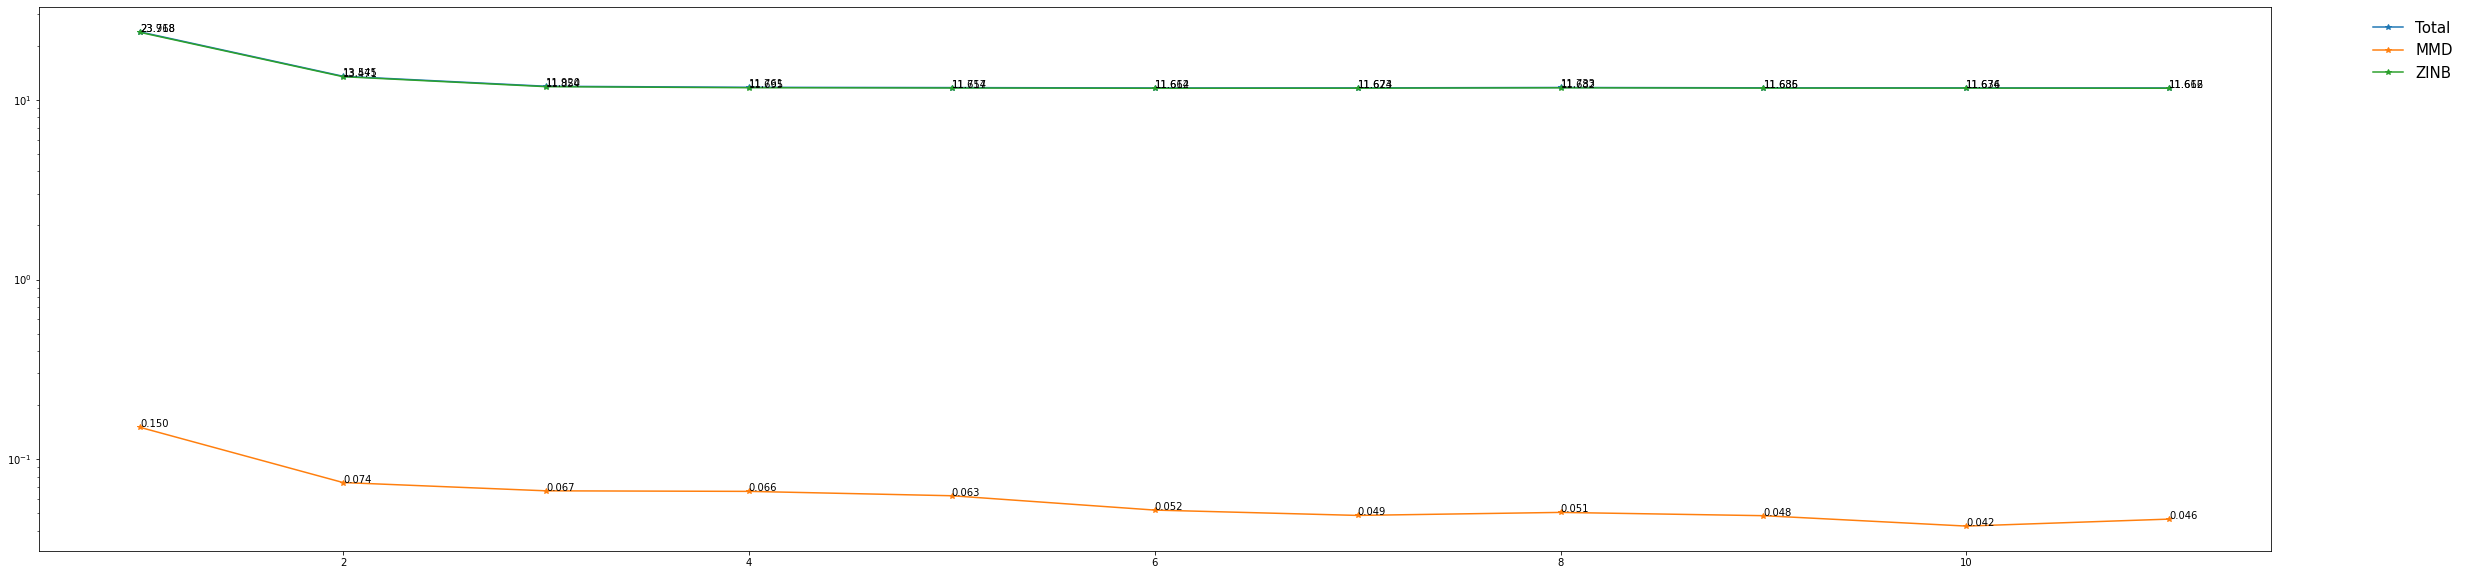

In [16]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))    


## Visualization of batch 5 and 6
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


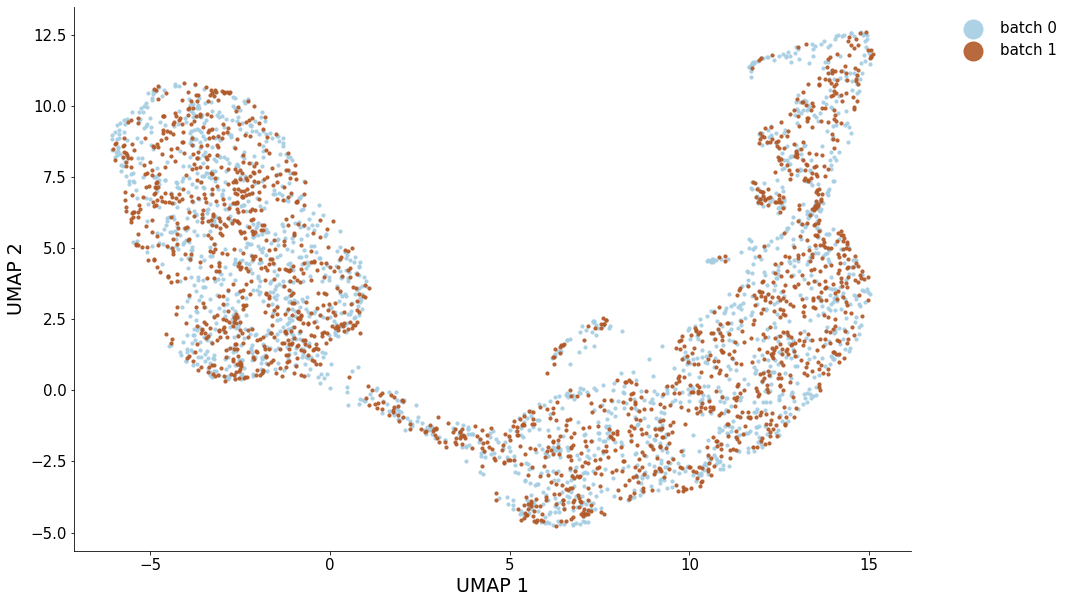

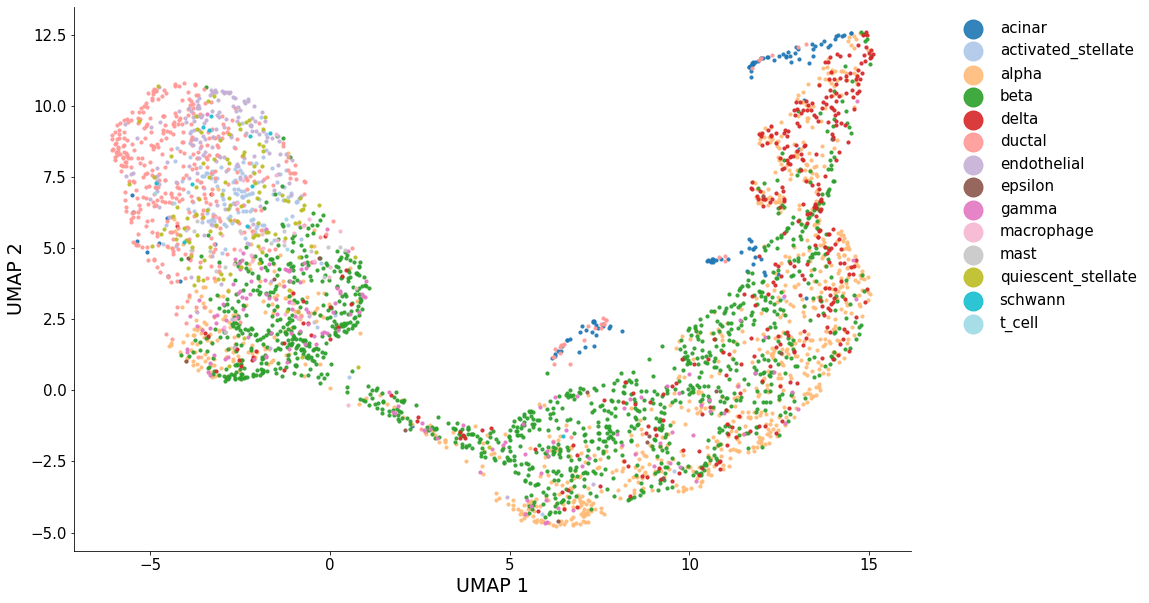

In [17]:
zs = []
test_loaders_sub = [test_loaders[4], test_loaders[5]]
nbatches_sub = len(test_loaders_sub)
for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

annos_sub = [annos[4], annos[5]]
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


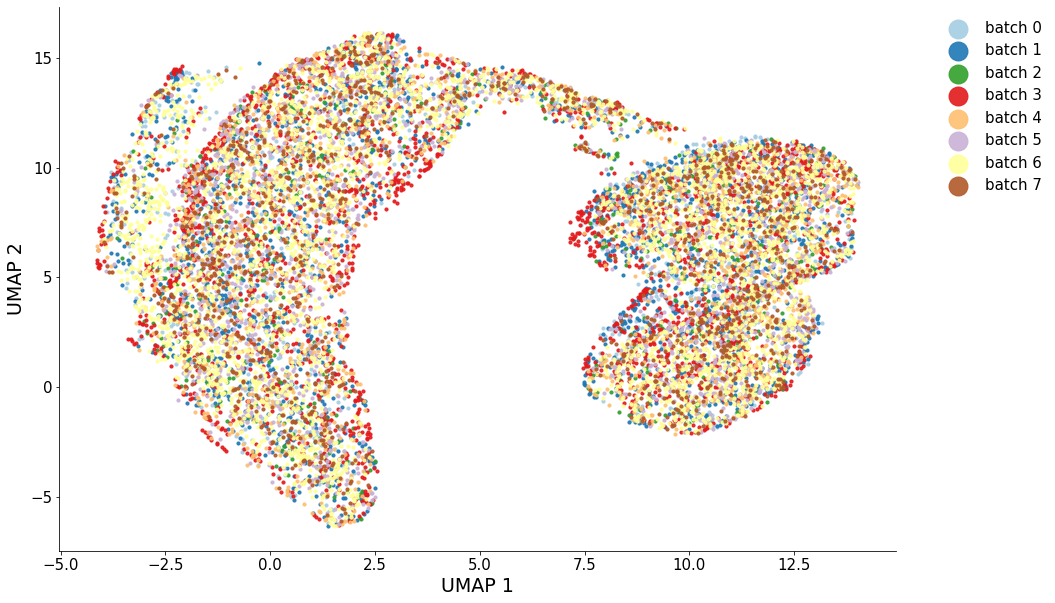

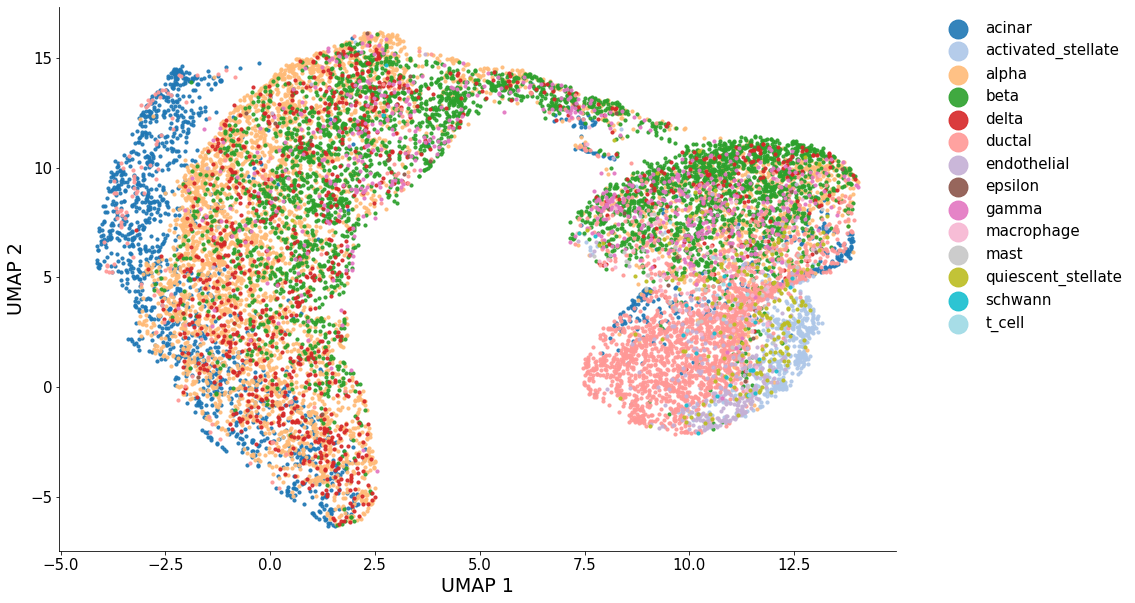

In [18]:
zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


# OLD

## Loading the dataset
We use the Pancreas data from paper (https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2),
which has 8 batches but no time information

In [8]:
# Load pancreas files info
pancreas_files = None
for roots, dirs, files in os.walk('./data/Pancreas'):
    pancreas_files = files

mtx_file_lst = [i for i in pancreas_files if i.endswith('.npz')]
meta_file_lst = [i for i in pancreas_files if i.endswith('.csv') and 'meta' in i]
gene_file = [i for i in pancreas_files if 'gene' in i]
print(mtx_file_lst, meta_file_lst, gene_file)

['GxC2.npz', 'GxC1.npz', 'GxC6.npz', 'GxC7.npz', 'GxC3.npz', 'GxC5.npz', 'GxC0.npz', 'GxC4.npz'] ['meta_c5.csv', 'meta_c1.csv', 'meta_c2.csv', 'meta_c7.csv', 'meta_c4.csv', 'meta_c0.csv', 'meta_c3.csv', 'meta_c6.csv'] ['gene.csv']


In [9]:
path_base = r'./data/Pancreas/'
batch_num_1, batch_num_2 = 0, 5
data_batch_1, data_anno_1, data_batch_2, data_anno_2 = load_batches(batch_num_1, batch_num_2, 
                                                        meta_file_lst, mtx_file_lst, path_base)
anno_1, anno_2 = np.array(data_anno_1['celltype']), np.array(data_anno_2['celltype'])
print(len(list(set(anno_1))), len(list(set(anno_2))))

Loading batch file 1: GxC0.npz	 with meta file 1:meta_c0.csv
Loading batch file 1: GxC5.npz	 with meta file 1:meta_c5.csv
Batch 1 size:(1004, 8634)	Meta 1 size:(1004, 2)
Batch 2 size:(1724, 8634)	Meta 2 size:(1724, 2)
13 14


In [10]:
# All batches use this fixed map of cell types and numbers to plot
cell_types_unique = ['activated_stellate', 'quiescent_stellate', 'epsilon', 'endothelial', 'mast', 'schwann', 'alpha', 't_cell', 'gamma', 'delta', 'macrophage', 'ductal', 'acinar', 'beta']
maps = dict(zip(range(len(cell_types_unique)), cell_types_unique))
print(maps)

{0: 'activated_stellate', 1: 'quiescent_stellate', 2: 'epsilon', 3: 'endothelial', 4: 'mast', 5: 'schwann', 6: 'alpha', 7: 't_cell', 8: 'gamma', 9: 'delta', 10: 'macrophage', 11: 'ductal', 12: 'acinar', 13: 'beta'}


### Training

Loading batch file 1: GxC4.npz	 with meta file 1:meta_c4.csv
Loading batch file 1: GxC6.npz	 with meta file 1:meta_c6.csv
Batch 1 size:(1937, 8634)	Meta 1 size:(1937, 2)
Batch 2 size:(3605, 8634)	Meta 2 size:(3605, 2)

 EPOCH 1/200 	 train loss 0.8452495502083955

 EPOCH 2/200 	 train loss 0.8161689076893835

 EPOCH 3/200 	 train loss 0.8084663111460719

 EPOCH 4/200 	 train loss 0.8056013395814595

 EPOCH 5/200 	 train loss 0.8040360749598687


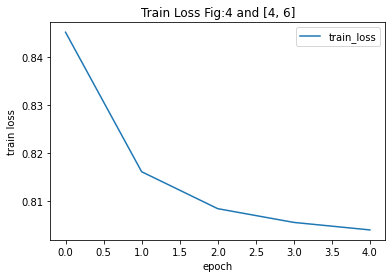


 EPOCH 6/200 	 train loss 0.801969277101752

 EPOCH 7/200 	 train loss 0.8010119042817502

 EPOCH 8/200 	 train loss 0.8003109551362297

 EPOCH 9/200 	 train loss 0.7992486141364354

 EPOCH 10/200 	 train loss 0.7986572454685886


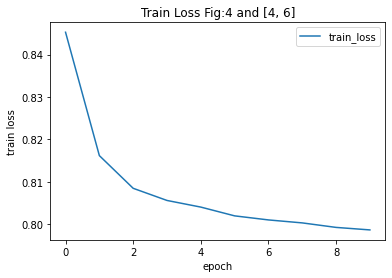


 EPOCH 11/200 	 train loss 0.798771349621853

 EPOCH 12/200 	 train loss 0.7988660061057844

 EPOCH 13/200 	 train loss 0.7982360237212174

 EPOCH 14/200 	 train loss 0.7983156636503472

 EPOCH 15/200 	 train loss 0.7985661082742875


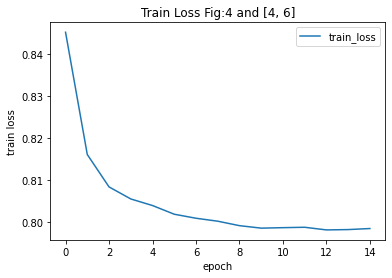


 EPOCH 16/200 	 train loss 0.7975090156834829

 EPOCH 17/200 	 train loss 0.7972379319127466

 EPOCH 18/200 	 train loss 0.7965043815805792

 EPOCH 19/200 	 train loss 0.7975815047784509

 EPOCH 20/200 	 train loss 0.7969261882350688


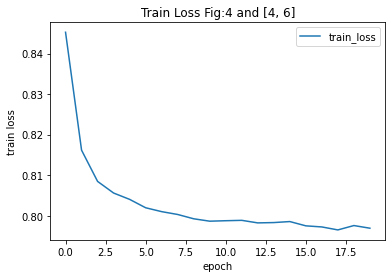


 EPOCH 21/200 	 train loss 0.7965054982214412

 EPOCH 22/200 	 train loss 0.7962396136250888

 EPOCH 23/200 	 train loss 0.7959511441303149

 EPOCH 24/200 	 train loss 0.7957154757962992

 EPOCH 25/200 	 train loss 0.7962953708315855


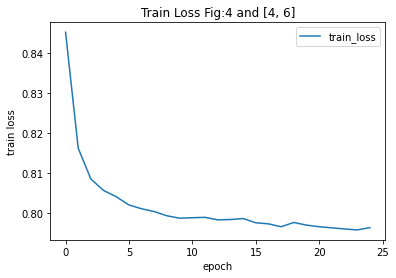


 EPOCH 26/200 	 train loss 0.7954330838212785

 EPOCH 27/200 	 train loss 0.7949193463106407

 EPOCH 28/200 	 train loss 0.7954404296244797

 EPOCH 29/200 	 train loss 0.7953994880955922

 EPOCH 30/200 	 train loss 0.7947881616878952


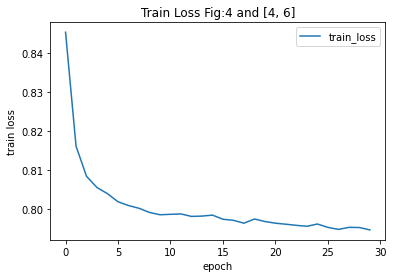


 EPOCH 31/200 	 train loss 0.7946168370756466

 EPOCH 32/200 	 train loss 0.7944436573034472

 EPOCH 33/200 	 train loss 0.7941156327262883

 EPOCH 34/200 	 train loss 0.7944965845047967

 EPOCH 35/200 	 train loss 0.7937076767511323


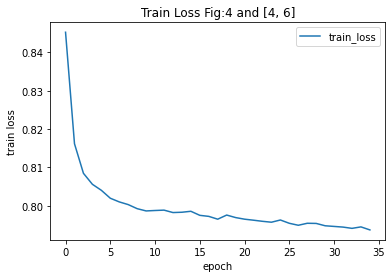


 EPOCH 36/200 	 train loss 0.7939073467106935

 EPOCH 37/200 	 train loss 0.7932846727110272

 EPOCH 38/200 	 train loss 0.7936023875617094

 EPOCH 39/200 	 train loss 0.7924880882976101

 EPOCH 40/200 	 train loss 0.7924153313663859


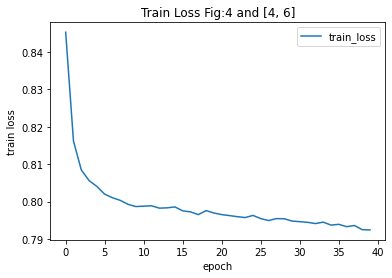


 EPOCH 41/200 	 train loss 0.7913333733302143

 EPOCH 42/200 	 train loss 0.7912067675258182

 EPOCH 43/200 	 train loss 0.7910094253784242

 EPOCH 44/200 	 train loss 0.7914119399449354

 EPOCH 45/200 	 train loss 0.7907020261623715


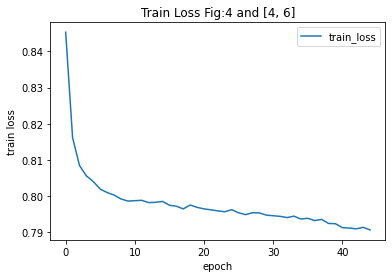


 EPOCH 46/200 	 train loss 0.7911796136559687

 EPOCH 47/200 	 train loss 0.7910716579202899

 EPOCH 48/200 	 train loss 0.7914898822648536

 EPOCH 49/200 	 train loss 0.7915000501956654

 EPOCH 50/200 	 train loss 0.7903927816332894


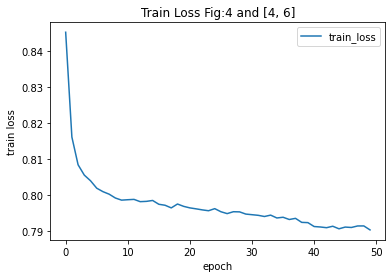


 EPOCH 51/200 	 train loss 0.7909086992522768

 EPOCH 52/200 	 train loss 0.7904660407574938

 EPOCH 53/200 	 train loss 0.7903625397689575

 EPOCH 54/200 	 train loss 0.7904448876014123

 EPOCH 55/200 	 train loss 0.7895654748257867


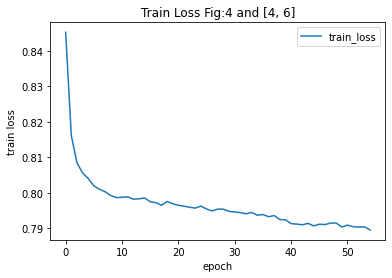


 EPOCH 56/200 	 train loss 0.789746774369192

 EPOCH 57/200 	 train loss 0.789554540804507

 EPOCH 58/200 	 train loss 0.7907180786132812

 EPOCH 59/200 	 train loss 0.7902265912057447

 EPOCH 60/200 	 train loss 0.7894981140073698


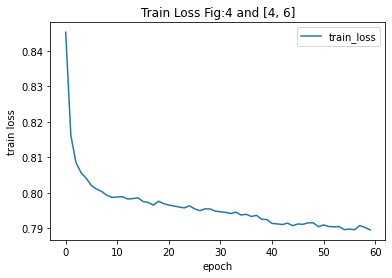


 EPOCH 61/200 	 train loss 0.790076315372213

 EPOCH 62/200 	 train loss 0.7894682876831117

 EPOCH 63/200 	 train loss 0.7898681750910517

 EPOCH 64/200 	 train loss 0.7896374282482425

 EPOCH 65/200 	 train loss 0.7886127655076562


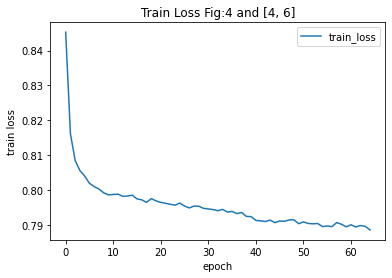


 EPOCH 66/200 	 train loss 0.7892091245951576

 EPOCH 67/200 	 train loss 0.7897056989221765

 EPOCH 68/200 	 train loss 0.7890508491228583

 EPOCH 69/200 	 train loss 0.7892045300217344

 EPOCH 70/200 	 train loss 0.7896070032311766


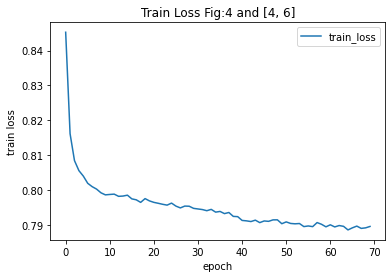


 EPOCH 71/200 	 train loss 0.7892009910382619

 EPOCH 72/200 	 train loss 0.7899856232587492

 EPOCH 73/200 	 train loss 0.7895922505738628

 EPOCH 74/200 	 train loss 0.7894833140848344

 EPOCH 75/200 	 train loss 0.78904384402313


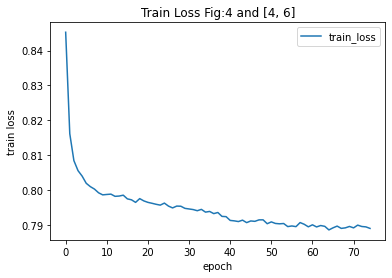


 EPOCH 76/200 	 train loss 0.7886395924597225

 EPOCH 77/200 	 train loss 0.7892367333927657

 EPOCH 78/200 	 train loss 0.7886294678553639

 EPOCH 79/200 	 train loss 0.7883337726898272

 EPOCH 80/200 	 train loss 0.7888810803241563


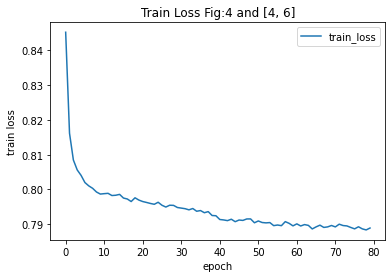


 EPOCH 81/200 	 train loss 0.7885806763609107

 EPOCH 82/200 	 train loss 0.7882594993327411

 EPOCH 83/200 	 train loss 0.7883970430971854

 EPOCH 84/200 	 train loss 0.7880844880332021

 EPOCH 85/200 	 train loss 0.7879448330888567


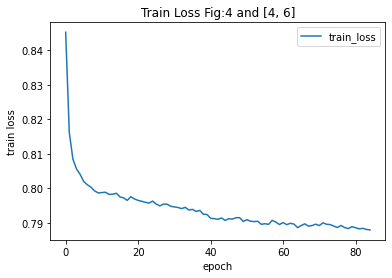


 EPOCH 86/200 	 train loss 0.7883187285636465

 EPOCH 87/200 	 train loss 0.7883709152765229

 EPOCH 88/200 	 train loss 0.78858195449128

 EPOCH 89/200 	 train loss 0.7883811639520885

 EPOCH 90/200 	 train loss 0.7878730431252924


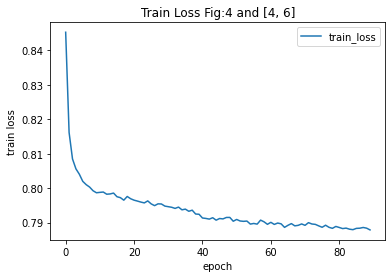


 EPOCH 91/200 	 train loss 0.7884127134875533

 EPOCH 92/200 	 train loss 0.7882025880670819

 EPOCH 93/200 	 train loss 0.7885909762404663

 EPOCH 94/200 	 train loss 0.7882246038134589

 EPOCH 95/200 	 train loss 0.787870963455539


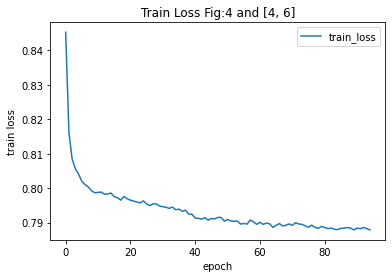


 EPOCH 96/200 	 train loss 0.7878200135159628

 EPOCH 97/200 	 train loss 0.787803468718994

 EPOCH 98/200 	 train loss 0.7877669839066331

 EPOCH 99/200 	 train loss 0.7873475641458381

 EPOCH 100/200 	 train loss 0.7884680807559713


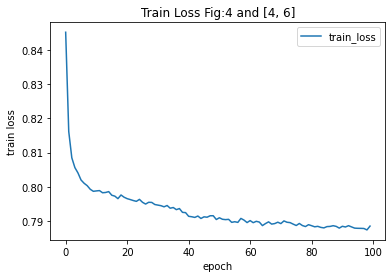


 EPOCH 101/200 	 train loss 0.7877434556731626

 EPOCH 102/200 	 train loss 0.7883926631866439

 EPOCH 103/200 	 train loss 0.7877635867188256

 EPOCH 104/200 	 train loss 0.7879241762176026

 EPOCH 105/200 	 train loss 0.7884955260946878


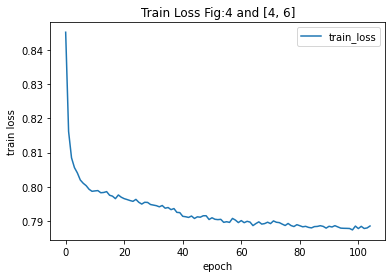


 EPOCH 106/200 	 train loss 0.7879246508392035

 EPOCH 107/200 	 train loss 0.7880945397703439

 EPOCH 108/200 	 train loss 0.7877572177302056

 EPOCH 109/200 	 train loss 0.7880456951025164

 EPOCH 110/200 	 train loss 0.7877550159586294


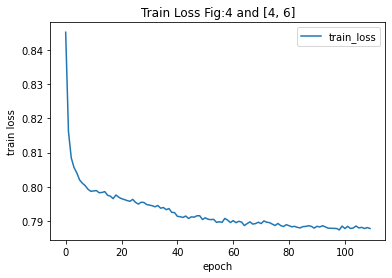


 EPOCH 111/200 	 train loss 0.788305762137835

 EPOCH 112/200 	 train loss 0.788144097355265

 EPOCH 113/200 	 train loss 0.7876481000578274

 EPOCH 114/200 	 train loss 0.7876141498429786

 EPOCH 115/200 	 train loss 0.7874928968249367


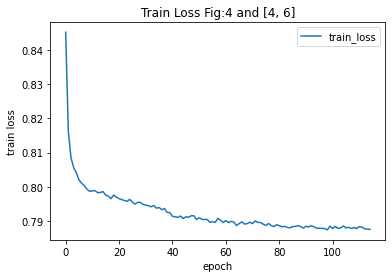


 EPOCH 116/200 	 train loss 0.7872853749304256

 EPOCH 117/200 	 train loss 0.7874596910373292

 EPOCH 118/200 	 train loss 0.7877936670936502

 EPOCH 119/200 	 train loss 0.7878218095943863

 EPOCH 120/200 	 train loss 0.7878760031097995


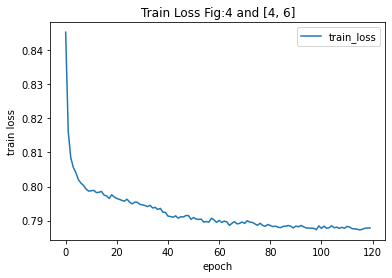


 EPOCH 121/200 	 train loss 0.7878539164655899

 EPOCH 122/200 	 train loss 0.7876161271047518

 EPOCH 123/200 	 train loss 0.78776642460151

 EPOCH 124/200 	 train loss 0.7875703349824904

 EPOCH 125/200 	 train loss 0.7874440620040303


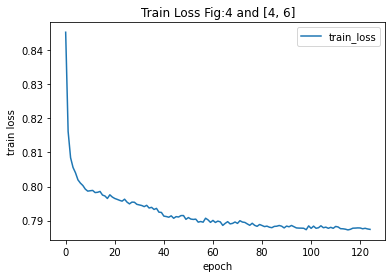


 EPOCH 126/200 	 train loss 0.7878214039012336

 EPOCH 127/200 	 train loss 0.788436326404546

 EPOCH 128/200 	 train loss 0.7874756509271797

 EPOCH 129/200 	 train loss 0.7872439587799371

 EPOCH 130/200 	 train loss 0.7880072133345399


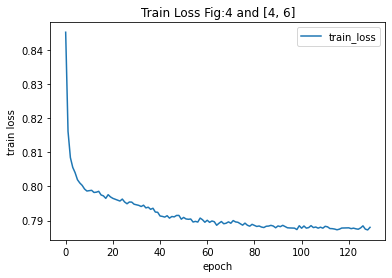


 EPOCH 131/200 	 train loss 0.7878439631976599

 EPOCH 132/200 	 train loss 0.7875590602577379

 EPOCH 133/200 	 train loss 0.7874155906161268

 EPOCH 134/200 	 train loss 0.788000511519984

 EPOCH 135/200 	 train loss 0.7875900268554688


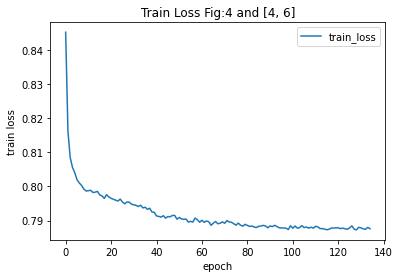


 EPOCH 136/200 	 train loss 0.7877196812666626

 EPOCH 137/200 	 train loss 0.7873433063371192

 EPOCH 138/200 	 train loss 0.7876545379748957

 EPOCH 139/200 	 train loss 0.7881798653117639

 EPOCH 140/200 	 train loss 0.7881462321677771


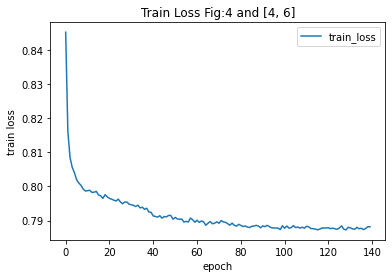


 EPOCH 141/200 	 train loss 0.7874246458448451

 EPOCH 142/200 	 train loss 0.7876394544610302

 EPOCH 143/200 	 train loss 0.7875370248175184

 EPOCH 144/200 	 train loss 0.7874502517786848

 EPOCH 145/200 	 train loss 0.7878668848607856


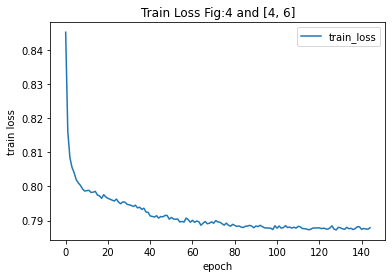


 EPOCH 146/200 	 train loss 0.7887706254398816

 EPOCH 147/200 	 train loss 0.7875065466270782

 EPOCH 148/200 	 train loss 0.7874783036877461

 EPOCH 149/200 	 train loss 0.7881255418169911

 EPOCH 150/200 	 train loss 0.7881280902001928


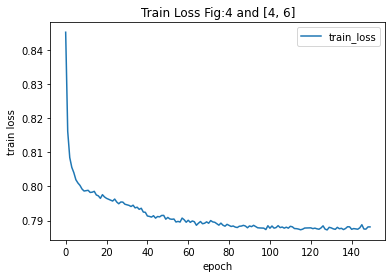


 EPOCH 151/200 	 train loss 0.788327785761749

 EPOCH 152/200 	 train loss 0.7878168132665789

 EPOCH 153/200 	 train loss 0.7875759437887953

 EPOCH 154/200 	 train loss 0.78817803181504

 EPOCH 155/200 	 train loss 0.7879144080717907


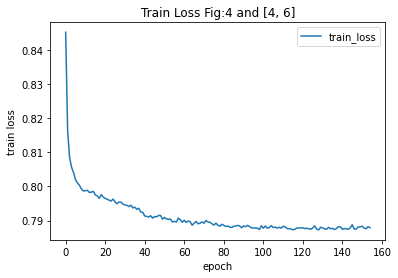


 EPOCH 156/200 	 train loss 0.7871359616871895

 EPOCH 157/200 	 train loss 0.7880751078560848

 EPOCH 158/200 	 train loss 0.7880319586474684

 EPOCH 159/200 	 train loss 0.7875527523200292

 EPOCH 160/200 	 train loss 0.7881474177370874


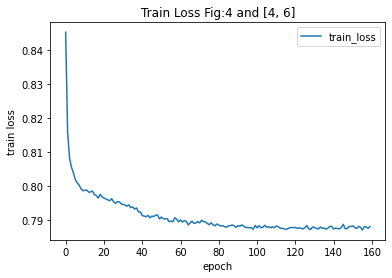


 EPOCH 161/200 	 train loss 0.7878106353082297

 EPOCH 162/200 	 train loss 0.7871548027861777

 EPOCH 163/200 	 train loss 0.7875700257891654

 EPOCH 164/200 	 train loss 0.7875519153317287

 EPOCH 165/200 	 train loss 0.7880323407080103


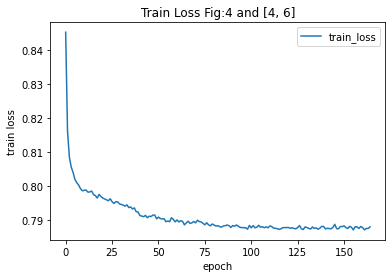


 EPOCH 166/200 	 train loss 0.7876343242150948

 EPOCH 167/200 	 train loss 0.7871544167868674

 EPOCH 168/200 	 train loss 0.7875548398673196

 EPOCH 169/200 	 train loss 0.7872818910897117

 EPOCH 170/200 	 train loss 0.788317182597021


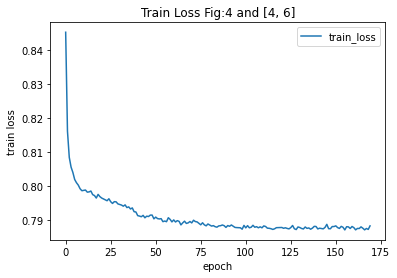


 EPOCH 171/200 	 train loss 0.7878258133525385

 EPOCH 172/200 	 train loss 0.7884570325104059

 EPOCH 173/200 	 train loss 0.788313131573647

 EPOCH 174/200 	 train loss 0.7873518081688672

 EPOCH 175/200 	 train loss 0.7875017649621525


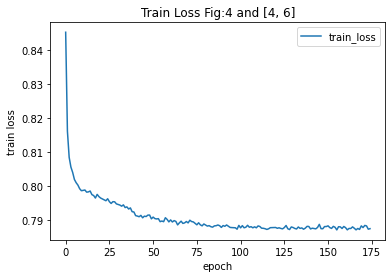


 EPOCH 176/200 	 train loss 0.787081858763451

 EPOCH 177/200 	 train loss 0.7882251532716609

 EPOCH 178/200 	 train loss 0.7873943212663752

 EPOCH 179/200 	 train loss 0.7877215817224505

 EPOCH 180/200 	 train loss 0.787647912966325


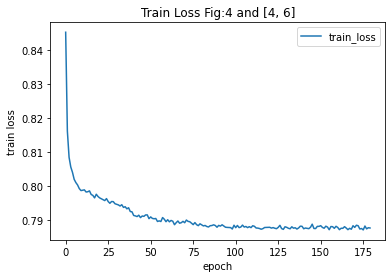


 EPOCH 181/200 	 train loss 0.7877642366156236

 EPOCH 182/200 	 train loss 0.7880923045192358

 EPOCH 183/200 	 train loss 0.7871540150324832

 EPOCH 184/200 	 train loss 0.7874879576092721

 EPOCH 185/200 	 train loss 0.7879755023095678


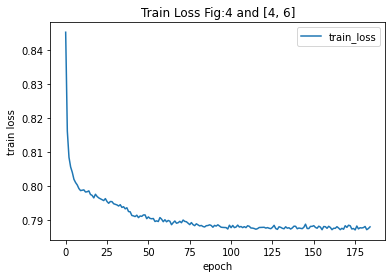


 EPOCH 186/200 	 train loss 0.7875475236048819

 EPOCH 187/200 	 train loss 0.7877614459981608

 EPOCH 188/200 	 train loss 0.787889119208813

 EPOCH 189/200 	 train loss 0.7880141829853521

 EPOCH 190/200 	 train loss 0.7882341060923989


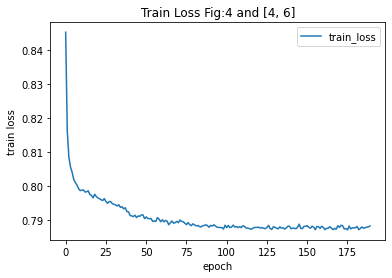


 EPOCH 191/200 	 train loss 0.7874154133715455

 EPOCH 192/200 	 train loss 0.7874974894289756

 EPOCH 193/200 	 train loss 0.788520011448897

 EPOCH 194/200 	 train loss 0.7876757974777261

 EPOCH 195/200 	 train loss 0.7872841027082089


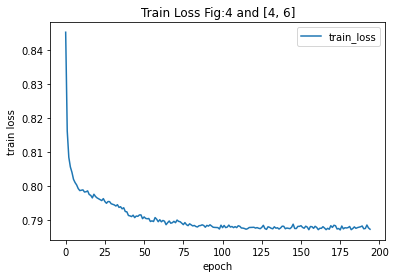


 EPOCH 196/200 	 train loss 0.7879203142551152

 EPOCH 197/200 	 train loss 0.7869765006455799

 EPOCH 198/200 	 train loss 0.7875952831419953

 EPOCH 199/200 	 train loss 0.7873260643781308

 EPOCH 200/200 	 train loss 0.7875336000583316


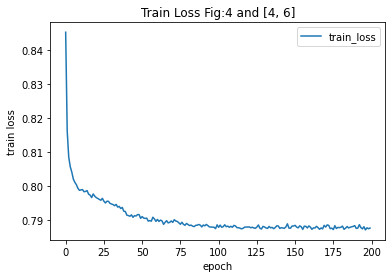

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


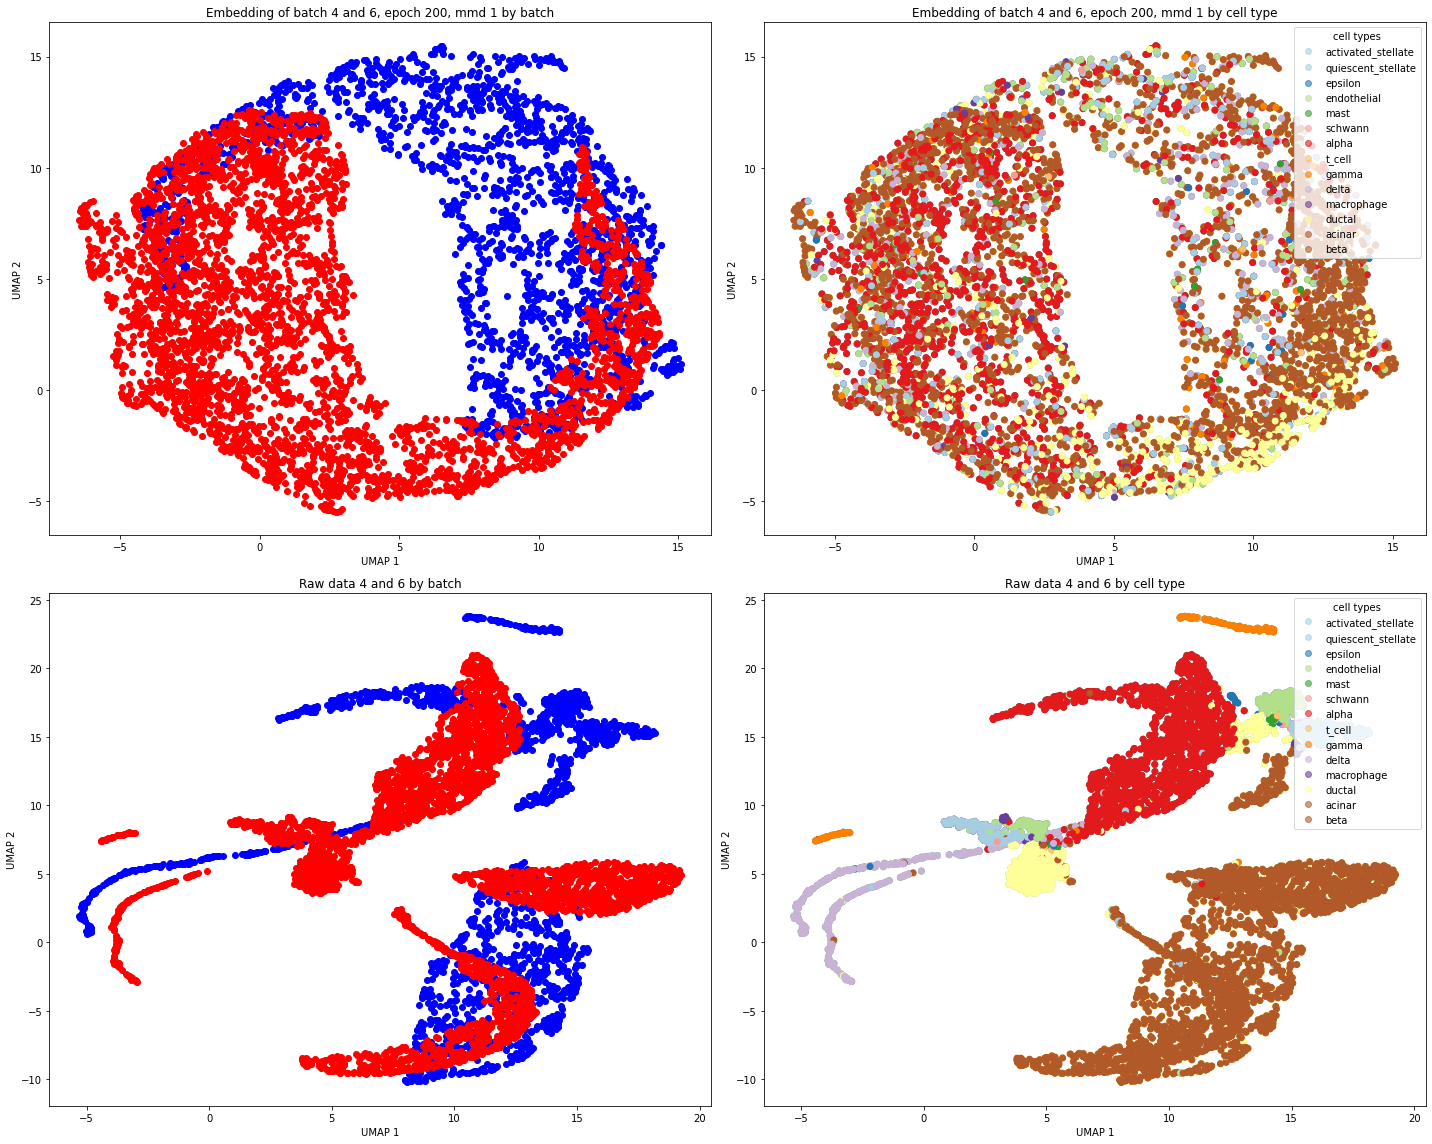

In [14]:
for i in range(0, 7):
    for j in range(i+1, 8):
        batch_num_1 = i
        batch_num_2 = j

        data_batch_1, data_anno_1, data_batch_2, data_anno_2 = load_batches(batch_num_1, batch_num_2, 
                                                                meta_file_lst, mtx_file_lst, path_base)
        anno_1, anno_2 = np.array(data_anno_1['celltype']), np.array(data_anno_2['celltype'])

        batch_size = 50
        seed = 222
        random.seed(seed)

        # construct training and testing dataset for one batch (day 4)
        train_data_1 = dataset(counts = data_batch_1, anno = anno_1)
        train_loader_1 = DataLoader(train_data_1, batch_size = batch_size, shuffle=True)

        train_data_2 = dataset(counts = data_batch_2, anno = anno_2)
        train_loader_2 = DataLoader(train_data_2, batch_size = batch_size, shuffle = True)

        if data_batch_1.shape != data_batch_2.shape:
            assert ValueError
        net_struc = [data_batch_1.shape[1],128, 32, 8]

        encoder = Encoder(features=net_struc).to(device)
        decoder = Decoder(features=net_struc[1:][::-1]).to(device)

        # Three output layer of DCA
        output_layer = OutputLayer(net_struc[:2][::-1]).to(device)

        # Define Optimizer
        lr = 1e-3

        #Random seed
        torch.manual_seed(seed)
        param_to_optimize = [
            {'params': encoder.parameters()},
            {'params': decoder.parameters()}
        ]

        optim = torch.optim.Adam(param_to_optimize, lr=lr)

        factor_zinb = 1
        factor_mmd = 1

        num_epochs = 200
        all_loss = {'train_loss':[],'test_loss':[]}
        for epoch in range(num_epochs):
            train_loss = train_epoch_mmd(encoder,decoder,output_layer,train_loader_1, train_loader_2,optim,factor_zinb,factor_mmd)
            print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
            all_loss['train_loss'].append(train_loss)
            all_loss['test_loss'].append(0)
            if epoch and (epoch + 1) % 5 == 0:
                plot_train(all_loss, batches=[batch_num_1, batch_num_2])

        test_loader_2 = DataLoader(train_data_2, batch_size = train_data_2.counts.shape[0], shuffle = False)
        test_loader_1 = DataLoader(train_data_1, batch_size = train_data_1.counts.shape[0], shuffle = False)

        vis_embedding(test_loader_1, test_loader_2, encoder, device,
                    title = "Embedding of batch {} and {}, epoch {}, mmd {}".format(batch_num_1, batch_num_2, num_epochs, factor_mmd), batches = [batch_num_1, batch_num_2], maps=maps)

        plt.savefig('./16fold/'+'emb_{}_&_{}_epoch_{}_lr_fixsed_mmd_{}'.format(batch_num_1, batch_num_2, num_epochs, factor_mmd) + '.png')